<a href="https://colab.research.google.com/github/GeoffroyDeMeyer/GeoffroyDeMeyer/blob/main/ENS_DL_DIY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# **Classification  of  Lymphocytosis from Blood Cells**
## Deep Learning in medical imaging
---
---
#### Geoffroy de Meyer -- January 28, 2022

\\

\\





# **1. Utils**
---
---


## Packages
---

In [1]:
###### Image
from PIL import Image                                 # Load images
import imageio                                        # Load images

###### Dataset processing
from sklearn.model_selection import train_test_split  # Split datasets
from sklearn.model_selection import GroupKFold        # Split datasets during validation
from sklearn.metrics import balanced_accuracy_score   # Compute metrics

###### Deep Learning
import torch                                          # Deep Learning library
import torch.nn as nn                                 # Model definitio
import torchvision.transforms as T                    # Image transformation
import torchvision.transforms.functional as TF        # Image transformation
import torch.nn.functional as F                       # Image transformation
import torch.optim as optim                           # Model training

###### 
import os                                             # Folder creation
from google.colab import files                        # Download files
import sys                                            #
import time                                           # Compute processing time
import random                                         # Generate randomness
import numpy as np                                    # Array manipulation
import pandas as pd                                   # Data frame manipulation
import matplotlib.pyplot as plt                       # Plots
from copy import deepcopy                             # Copy objects
import ipywidgets as widgets                          # Conveniently display training
from IPython.display import display                   # Convenient display interrupt
from math import *                                    # Convenient functions

## Dataset loading
---

In [7]:
# Unzip file
! unzip -q DL_lymphocytosis.zip
print('\nData is ready!')


Data is ready!


## Definition of the paths
---

Now I will store the paths to the datasets into convenient variables.

Please check that the folders `trainset/` and `testset/` are present in your working directory, and change `orig_train` and `orig_test` accordingly if not.

In [8]:
! ls --color

orig_train = 'trainset/'
orig_test = 'testset/'

clinical_annotation.csv  sample_data            testset
DL_lymphocytosis.zip     sample_submission.csv  trainset


For my final validation I used preprocessed images. Since this preprocessing takes a lot of time, I already downloaded two .zip files containing those preprocessed images.

If you want to use these preprocessed images (which is recommended), please upload `trainset_preprocessed.zip` and `testset_preprocessed.zip` to the Google Colab working directory (4th icon on the left panel). I'll unzip them and store the path to the unzipped folders into convenient variables.

**Warning : uploading the files can take a bit of time, but an icon at the bottom of the left panel indicates that the work is in progress.**

In [ ]:
! unzip -q testset_preprocessed.zip
print('Testset unzipped')
! unzip -q trainset_preprocessed.zip
print('Trainset unzipped')

Testset unzipped
Trainset unzipped


Once both files are unzipped, please check that the folders `trainset_preprocessed/` and `testset_preprocessed/` are present in your working directory, and change `orig_train_preprocessed` and `orig_test_preprocessed` accordingly if not.

In [ ]:
! ls --color

orig_train_preprocessed = 'trainset_preprocessed/'
orig_test_preprocessed = 'testset_preprocessed/'

bin      home   opt         srv                       tools
boot     lib    proc        sys                       trainset_preprocessed
content  lib32  python-apt  tensorflow-1.15.2         trainset_preprocessed.zip
datalab  lib64  root        testset_preprocessed      usr
dev      media  run         testset_preprocessed.zip  var
etc      mnt    sbin        tmp


# **2. Clinical annotations**
---
---

## Load data frame
---

The first step consists in formatting the information relative to each patient, by converting the file `clinical_annotation.csv` into a data frame.

The cell below shows what files are in the current working directory. Please check that the file `clinical_annotation.csv` is present, and change `clinical_path ` accordingly if not.

In [10]:
! ls --color
clinical_path = 'clinical_annotation.csv'

clinical_annotation.csv  sample_data            testset
DL_lymphocytosis.zip     sample_submission.csv  trainset


In [11]:
df_clinical = pd.read_csv(clinical_path, index_col=0)
df_clinical.head(5)

ID  LABEL GENDER        DOB  LYMPH_COUNT
0   P26      1      M  11/3/1933         11.2
1  P183      1      M  5/15/1942         12.8
2   P89      1      M  6/19/1935          9.6
3  P123      1      M  1/27/1931        122.6
4   P61      1      F   3/5/1931         11.6

There is a few work to do on this dataset.


1.   Remove the patients with label -1, who correspond to participants in the testing set
2.   Convert the column DOB (date of birth) into a more convenient column AGE containing the age of each participant in 2021



In [12]:
def convert_DOB(df):
  """
  Changes the DOB (date of birth) column of a dataframe into an AGE column,
  containing the age of each participant in 2021. (Time of the acquisition of the data)
  --------------------
  Input: data frame
  Output: data frame
  """
  for i in range(len(df)):
    df['DOB'][i] = 2021 - int(df['DOB'][i][-4:])
    
  df = df.rename(columns={"DOB": "AGE"})
  return df

pd.options.mode.chained_assignment = None # We are not concerned by the warning messages

# 1.Drop patients with label -1 who belong to the testing set
df_clinical = df_clinical[df_clinical.LABEL >= 0].reset_index(drop=True)
# 2. Convert date of birth into age
df_clinical = convert_DOB(df_clinical)

df_clinical.head(5)

ID  LABEL GENDER AGE  LYMPH_COUNT
0   P26      1      M  88         11.2
1  P183      1      M  79         12.8
2   P89      1      M  86          9.6
3  P123      1      M  90        122.6
4   P61      1      F  90         11.6

## Data overview
---

We can start by computing the proportion of healthy and unhealthy participants in the training set.

In [13]:
p_m = len(df_clinical[df_clinical.LABEL == 1])/ (len(df_clinical[df_clinical.LABEL == 1])+ len(df_clinical[df_clinical.LABEL == 0]))
print(f'The training set is composed of {100*round(1-p_m, 3)}% healthy participants, and {100*round(p_m, 3)}% unhealthy participants.')

The training set is composed of 30.7% healthy participants, and 69.3% unhealthy participants.


Both classes (unhealthy and healthy) appear to be pretty unbalanced, which will have to be taken into account during the training of the model.

### Diving into the data : distributions of lymphocyte count, age and gender across healthy and unhealthy participants




It is interesting to visualise the distribution of potential confounding factors across healthy and unhealthy participants. Indeed, we would like to incorporate the clinical information to the image learning, and the first thing to do is to see how much the distribution of these clinical factors impact the state of the participant (healthy or unhealthy).


In [14]:
def display_hist(data_healthy, data_unhealthy, binwidth, display_stats) :
  """
  Displays an histogram (with the parameter binwidth) representing the 
  distribution of healthy and unhealthy participants depending on a given 
  factor. If display_stats=True, also displays a vertical dotted line for the 
  mean and a vertical dashed line for the median.
  --------------------
  Inputs: array, array, float, bool
  Output: None
  """
  # Healthy
  plt.hist(data_healthy, bins=np.arange(min(data_healthy), max(data_healthy) + binwidth, binwidth), label=f'{len(data_healthy)} healthy participants', color='C0', alpha=0.5)
  if display_stats :
    mean_healthy = np.mean(data_healthy)
    median_healthy = np.median(data_healthy)
    plt.axvline(mean_healthy, linestyle='dotted', color='C0')
    plt.axvline(median_healthy, linestyle='dashed', color='C0')
  # Unhealthy
  plt.hist(data_unhealthy, bins=np.arange(min(data_unhealthy), max(data_unhealthy) + binwidth, binwidth), label=f'{len(data_unhealthy)} unhealthy participants', color='C1', alpha=0.5)
  if display_stats :
    mean_unhealthy = np.mean(data_unhealthy)
    median_unhealthy = np.median(data_unhealthy)
    plt.axvline(mean_unhealthy, linestyle='dotted', color='C1')
    plt.axvline(median_unhealthy, linestyle='dashed', color='C1')

**1. Lymphocyte count distribution**

First, we'll display as histograms the number of healthy and unhealthy participants depending on the *lymphocyte count* factor.

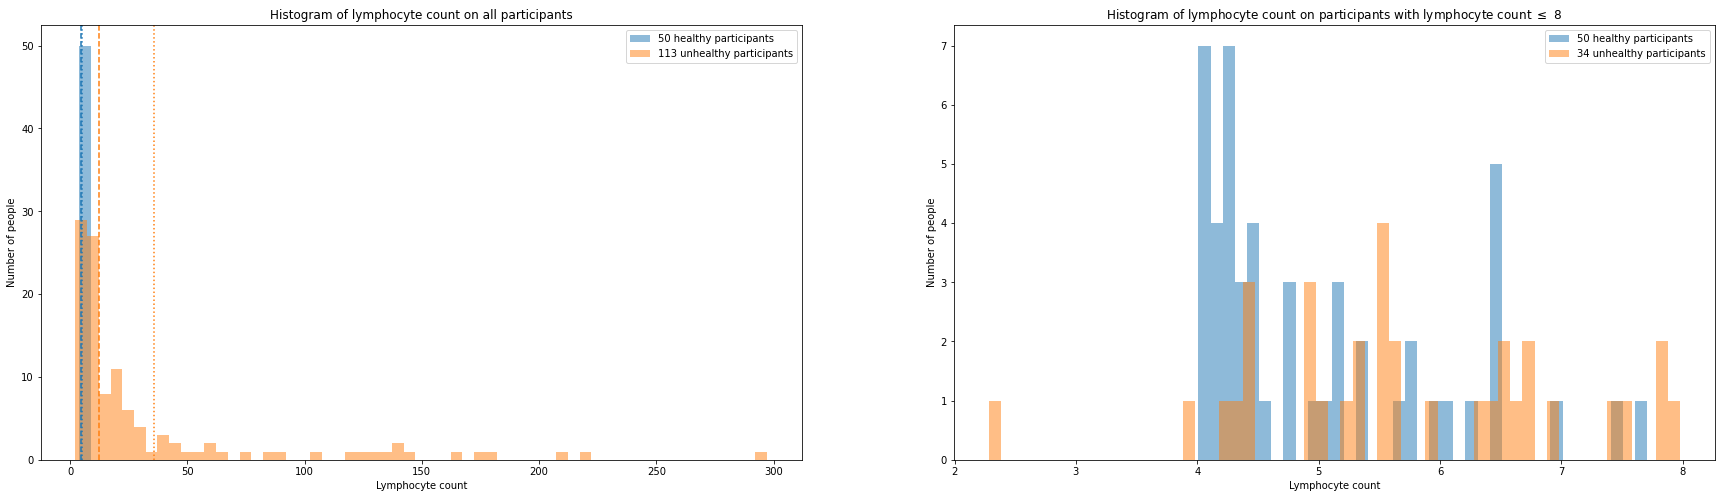

In [15]:
plt.subplots(1, 2, figsize=(30,8))

## Left : Histogram on all participants
plt.subplot(1, 2, 1)
binwidth = 5

data_healthy = df_clinical[df_clinical.LABEL==0].LYMPH_COUNT
data_unhealthy = df_clinical[df_clinical.LABEL==1].LYMPH_COUNT
display_hist(data_healthy, data_unhealthy, binwidth, True)

plt.xlabel('Lymphocyte count')
plt.ylabel('Number of people')
plt.title('Histogram of lymphocyte count on all participants')
plt.legend(loc='best')


## Right : Zoom, histogram on participants with LYMPH_COUNT <= 8
plt.subplot(1, 2, 2)
binwidth = 0.1

data_healthy = df_clinical[df_clinical.LABEL==0 & (df_clinical.LYMPH_COUNT <= 8)].LYMPH_COUNT
data_unhealthy = df_clinical[(df_clinical.LABEL==1) & (df_clinical.LYMPH_COUNT <= 8)].LYMPH_COUNT
display_hist(data_healthy, data_unhealthy, binwidth, False)

plt.xlabel('Lymphocyte count')
plt.ylabel('Number of people')
plt.title(r'Histogram of lymphocyte count on participants with lymphocyte count $\leq$ 8')
plt.legend(loc='best')

plt.show()

The dashed lines on the left plot correspond to the medians of both distribution, while the dotted lines correspond to the means.

It appears that all the 50 healthy participants of the dataset have a lymphocyte count smaller than 8, whereas the distribution of lymphocyte counts for unhealthy participants ranges from around 2 to 295, with a median around 12. It is tempting to think that every healthy participant has a lymphocyte count smaller than 8 and that every participant with a high lymphocyte count is unhealthy, but to nuance this information I will also focus on the age distribution across participants.

**2. Age distribution**

Second, I'll display as histograms the number of healthy and unhealthy participants depending on their *age*.

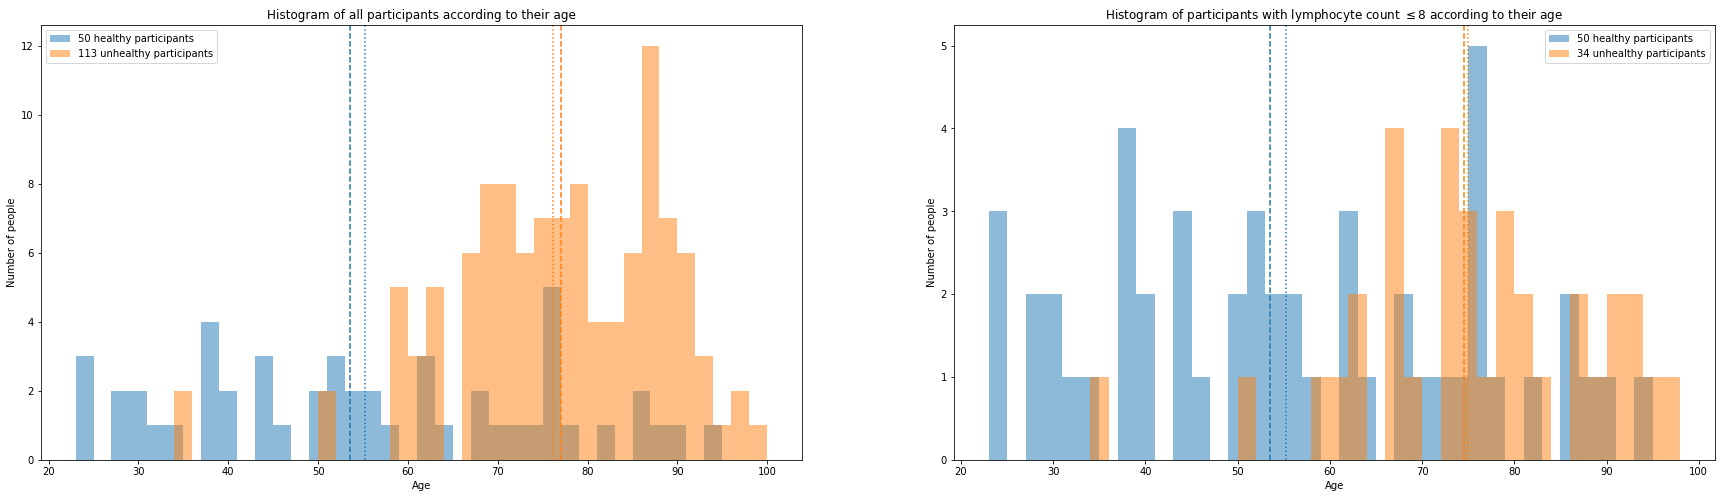

In [16]:
plt.subplots(1, 2, figsize=(30,8))


## Left plot : Histogram on all participants
plt.subplot(1,2,1)
binwidth = 2

data_healthy = df_clinical[df_clinical.LABEL==0].AGE
data_unhealthy = df_clinical[df_clinical.LABEL==1].AGE
display_hist(data_healthy, data_unhealthy, binwidth, True)

plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Histogram of all participants according to their age')
plt.legend(loc='best')


## Right plot : Zoom, histogram of participants with LYMPH_COUNT <= lymph_count
plt.subplot(1,2,2)
lymph_count = 8
binwidth = 2

data_healthy = df_clinical[(df_clinical.LABEL==0) & (df_clinical.LYMPH_COUNT <= lymph_count)].AGE
data_unhealthy = df_clinical[(df_clinical.LABEL==1) & (df_clinical.LYMPH_COUNT <= lymph_count)].AGE
display_hist(data_healthy, data_unhealthy, binwidth, True)

plt.xlabel('Age')
plt.ylabel('Number of people')
plt.title('Histogram of participants with lymphocyte count $\leq {l}$ according to their age'.format(l=lymph_count))
plt.legend(loc='best')

plt.show()

The dashed lines on the left plot correspond to the medians of both distribution, while the dotted lines correspond to the means.

It appears that healthy participants are much younger than unhealthy participants, with a median around 53 years old against a median around 77 years old. Yet, not all young participants with a lymhocyte count under 8 are healthy, as can be seen on the right plot : two participants are younger than 55 years old, with a lymphocyte count under 8, but are unhealthy.

**3. Influence of age, lymphocyte count and gender by pair of factors**

Finally, I can see how the three factors mentionned above interact together and if it is possible to see a pattern to separate healthy and unhealthy patients.

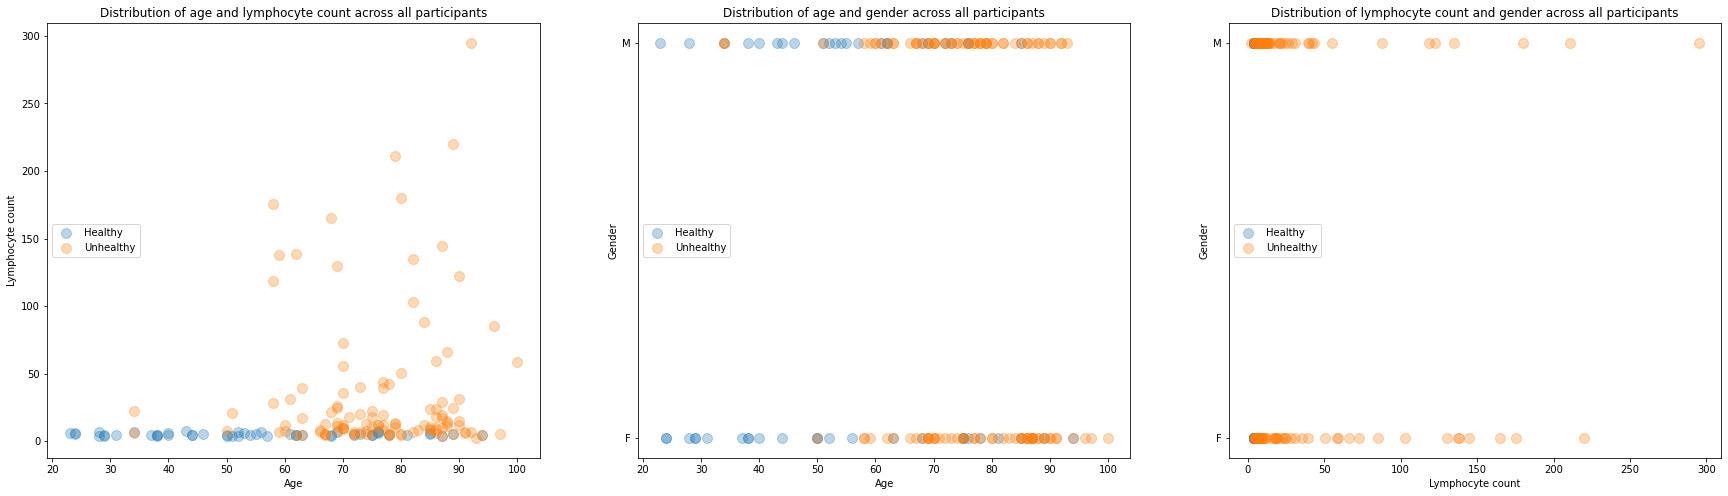

In [17]:
## Aggregate the data

healthy_age = []
healthy_lymphcount = []
healthy_gender = []
unhealthy_age = []
unhealthy_lymphcount = []
unhealthy_gender = []

for line in df_clinical.index:
  if df_clinical['LABEL'][line] :
    unhealthy_age.append(df_clinical['AGE'][line])
    unhealthy_lymphcount.append(df_clinical['LYMPH_COUNT'][line])
    unhealthy_gender.append(df_clinical['GENDER'][line]=='M')
  else :
    healthy_age.append(df_clinical['AGE'][line])
    healthy_lymphcount.append(df_clinical['LYMPH_COUNT'][line])
    healthy_gender.append(df_clinical['GENDER'][line]=='M')



fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

## Left plot : lymphocyte count and age
ax1.scatter(healthy_age, healthy_lymphcount, label='Healthy', alpha=0.3, color='C0', s=100)
ax1.scatter(unhealthy_age, unhealthy_lymphcount, label='Unhealthy', alpha=0.3, color='C1', s=100)
ax1.set_xlabel('Age')
ax1.set_ylabel('Lymphocyte count')
ax1.legend(loc='center left')
ax1.title.set_text('Distribution of age and lymphocyte count across all participants')

## Center plot : age and gender
ax2.scatter(healthy_age, healthy_gender, label='Healthy', alpha=0.3, color='C0', s=100)
ax2.scatter(unhealthy_age, unhealthy_gender, label='Unhealthy', alpha=0.3, color='C1', s=100)
ax2.set_xlabel('Age')
ax2.set_ylabel('Gender')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['F', 'M'])
ax2.legend(loc='center left')
ax2.title.set_text('Distribution of age and gender across all participants')

## Right plot : lymphocyte count and gender
ax3.scatter(healthy_lymphcount, healthy_gender, label='Healthy', alpha=0.3, color='C0', s=100)
ax3.scatter(unhealthy_lymphcount, unhealthy_gender, label='Unhealthy', alpha=0.3, color='C1', s=100)
ax3.set_xlabel('Lymphocyte count')
ax3.set_ylabel('Gender')
ax3.set_yticks([0,1])
ax3.set_yticklabels(['F', 'M'])
ax3.legend(loc='center left')
ax3.title.set_text('Distribution of lymphocyte count and gender across all participants')

plt.show()

The gender doesn't look like a counfounding factor to determinate if a participant is healthy or not, but the combination of the age and the lymphocyte count appears to be a rather strong indicator of the state of a participant. I should thus be able to apply a logistic regression on the clinical dataset to gain accuracy in predicting whether a participant is healthy or not.

## Logistic regression
---

Given the encouraging results seen above, I chose to apply a logistic regression to separate healthy and unhealthy participants based on their  age and lymphocyte count.

In [18]:
# Preparing the data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X = df_clinical[['AGE', 'LYMPH_COUNT']]
y = df_clinical['LABEL']

X_train, X_valid, y_train, y_valid =train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# Model training

model_logreg = LogisticRegression(solver='liblinear', C=10, random_state=0)
model_logreg.fit(X_train, y_train)

LogisticRegression(C=10, random_state=0, solver='liblinear')

I display a confusion matrix to visualise hits, false alarms, misses and correct rejections.

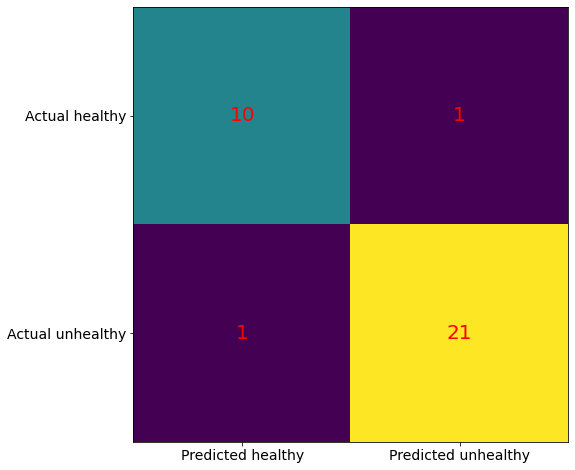

In [20]:
cm = confusion_matrix(y_valid, model_logreg.predict(X_valid))

# Plot parameters
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted healthy', 'Predicted unhealthy'))
for tick in ax.xaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual healthy', 'Actual unhealthy'))
for tick in ax.yaxis.get_major_ticks():
  tick.label.set_fontsize(14) 
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red', size=20)
plt.show()

With these raw results, I can compute more advanced metrics :

In [21]:
print(classification_report(y_valid, model_logreg.predict(X_valid), target_names = ['Healthy', 'Unhealthy']))

              precision    recall  f1-score   support

     Healthy       0.91      0.91      0.91        11
   Unhealthy       0.95      0.95      0.95        22

    accuracy                           0.94        33
   macro avg       0.93      0.93      0.93        33
weighted avg       0.94      0.94      0.94        33



If results seem pretty accurate, I shouldn't forget that they rely on a small dataset. We will of course work over the study of images in order to try to improve as much as possible those metrics. 

# **3. Image treatment**
---
---

Now that I better know how to use the clinical annotations, we can focus on the heart of the project, which is the images.

Since most images contained one or few lymphocytes in the foreground (in purple) and a lot of blood cells in the background, I came up with the idea of cropping the images around the lymphocytes. This should increase the precision of the model by removing unnecessary information, especially as our readings (for instance [Deep Multi-Instance Learning Using Multi-Modal Data
for Diagnosis of Lymphocytosis](https://hal.archives-ouvertes.fr/hal-03032875), paragraph 3.2) taught us that the lymphocytes themselves were important in the diagnosis of lymphocytosis, and not necessarily the other blood cells.

## Preprocessing
---

In order to crop the images as close as possible to the lymphocyte, I proceed as follows :

1.   Detection of all edges of the image with Sobel filters
2.   Thresholding of the image to keep only the sharpest edges
3.   Detection of the first non-zero pixel of the image from the top, the bottom, the right and the left of the image
4.   Cropping of the image conserving its square shape

The function `detect_edges` computes the first two steps, while the function `crop_around_lymphocyte` re-uses `detect_edges` and computes the last two steps.



In [22]:
def detect_edges(image):
  """ 
  Applies two Sobel filters to detect the edges of the image, then applies a
  threshold to keep only the sharpest edges.
  --------------------
  Input : image tensor (torchvision)
  Output : image tensor (torchvision)
  """
  # Sobel filters
  sobel_x = torch.tensor([[1., 0. , -1.], [2., 0., -2.], [1., 0. , -1.]]).expand(1,3,3,3)
  sobel_y = torch.tensor([[1., 2. , 1.], [0., 0., 0.], [-1., -2. , -1.]]).expand(1,3,3,3)
  # Edge detection on vertical and horizontal directions
  edges_x = F.conv2d(image[None], sobel_x, padding=0, stride=1)
  edges_y = F.conv2d(image[None], sobel_y, padding=0, stride=1)
  # Edge detection on all directions
  all_edges = torch.square(edges_x).add(torch.square(edges_y))
  # Thresholding
  thres = nn.Threshold(torch.max(all_edges)/3,0)(all_edges)
  return all_edges, thres


def crop_around_lymphocyte(image) :
  """
  Detects the top, bottom, right and left limit of the lymphocytes present in 
  an image, then crops the image to return a square image containing the 
  lymphocytes and as less background as possible.
  --------------------
  Input : image tensor in 3D (torchvision)
  Output : image tensor in 3D (torchvision)
  """

  # Detection of the edges
  thres = detect_edges(image)[1]
  thres_2d = thres[0,0]
  (x,y) = thres_2d.shape

  # Detection of the top, bottom, right and left limits of the lymphocyte
  i, j = 0, 0
  top = x-1
  bottom = 1
  right = 1
  left = y-1
  for i in range(x) :
    for j in range(y) :
      if thres_2d[i,j] > 0 :
        if top>i :
          top = i
        if left>j :
          left = j
        if bottom<i :
          bottom = i
        if right<j :
          right = j

  # Safety margin on all limits
  top, bottom, right, left = max(top-2,0), min(bottom+2,x), min(right+2,y), max(left-2,0)

  # If two limits are too close to correspond to a lymphocyte, the detection didn't work
  if (right-left < 50) or (bottom-top < 50) :
    cropped = T.CenterCrop(100)(image) # Just apply a general center crop that works most of the time

  else :
    size = max(bottom-top, right-left)//2 # size*2 = side of the new image
    middle_x = (bottom+top)//2 # horizontal line on which the new image will be centered
    middle_y = (left+right)//2 # vertical line on which the new image will be centered
    coords = middle_x-size, middle_x+size, middle_y-size, middle_y+size

    # Check for border effects
    if coords[0]<0 or coords[1]>x or coords[2]<0 or coords[3]>y :
      cropped = image # to keep a square size we need to return the whole image

    else :
      cropped = image[:, coords[0]:coords[1], coords[2]:coords[3]]

  return cropped

## Visualisation
---

Now I can see how the different steps of the process affect the image.

For the visualisation below, I randomly chose to display images of the participant P26, and found that the images of index 3 to 12 showed an interesting variety of cases. Of course you can play with the parameters to see other images.

Note that the last row corresponds to images that have been resized to have a side of 32 px. This is meant to reduce the computation time of the model, and to work with images of the same size.

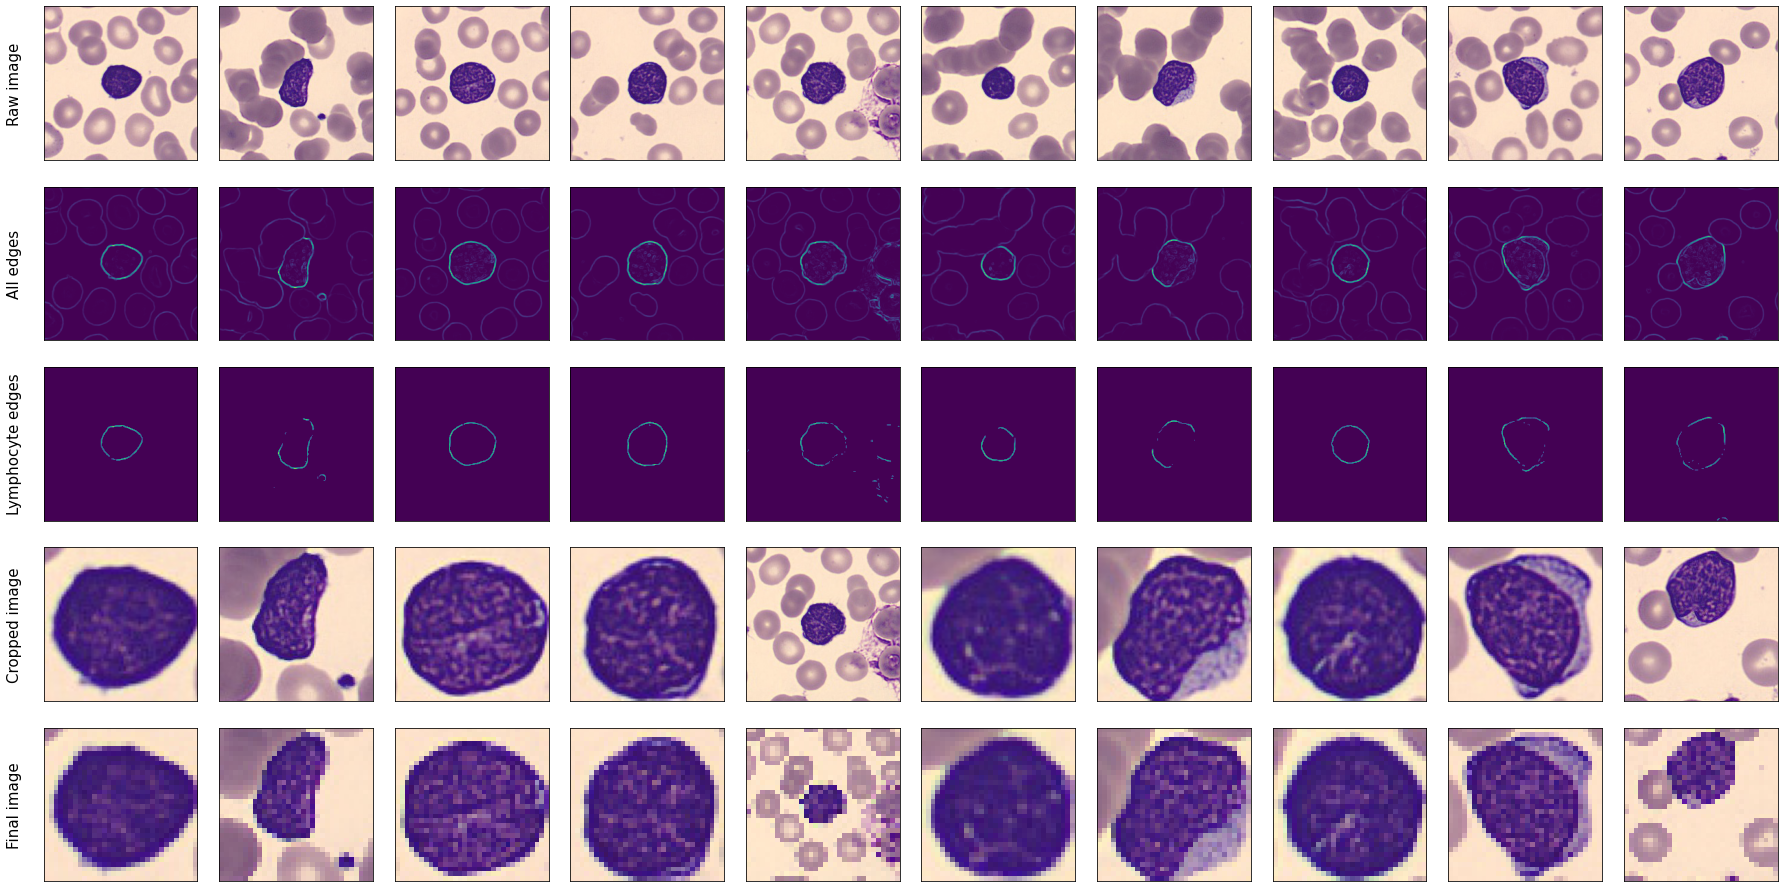

In [23]:
## Parameters : choose what images you want to see
patient_id = 'P26'
start_images = 3
end_images = 12

## Preparing the loop
nb_images = end_images-start_images+1
size_img = 2.5                          # size of each image in the display
paths = [orig_train + patient_id + '/' + img_name for img_name in os.listdir(orig_train + patient_id)] # list of all paths to the patient images


## Plot
plt.subplots(5, nb_images, figsize=(size_img*nb_images, size_img*5))

for i in range(start_images, end_images+1) :

  # Plot the raw image
  image = imageio.imread(paths[i])
  plt.subplot(5, nb_images, i+1-start_images)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if i==start_images :
    plt.ylabel('Raw image\n', size=15)

  # Plot the edges of the image
  image = T.ToTensor()(image)
  edges, thres = detect_edges(image)
  plt.subplot(5, nb_images, i+1-start_images+nb_images)
  plt.imshow(edges[0,0])
  plt.xticks([])
  plt.yticks([])
  if i==start_images :
    plt.ylabel('All edges\n', size=15)

  # Plot the edges thresholded of the image
  plt.subplot(5, nb_images, i+1-start_images+2*nb_images)
  plt.imshow(thres[0,0])
  plt.xticks([])
  plt.yticks([])
  if i==start_images :
    plt.ylabel('Lymphocyte edges\n', size=15)

  # Plot the cropped image
  cropped = crop_around_lymphocyte(image)
  plt.subplot(5, nb_images, i+1-start_images+3*nb_images)
  plt.imshow(T.ToPILImage()(cropped))
  plt.xticks([])
  plt.yticks([])
  if i==start_images :
    plt.ylabel('Cropped image\n', size=15)

  # Plot the final image
  resized = T.Resize(32)(cropped)
  plt.subplot(5, nb_images, i+1-start_images+4*nb_images)
  plt.imshow(T.ToPILImage()(resized))
  plt.xticks([])
  plt.yticks([])
  if i==start_images :
    plt.ylabel('Final image\n', size=15)

plt.tight_layout()

The image processing seems to work pretty well, as I found no deleted lymphocyte while exploring the dataset. Small dots are sometimes removed, but most of the time when there is an ambiguity the margin is high enough to avoid removing important information.

## Wrapping-up for the use in the model
---

All I have to do now is to gather all the steps needed to go from the raw image to the cropped, resized tensor image. First I want to make sure that the dimension of the image is conserved across the preprocessing.

In [24]:
print('Shape of the image...\n')

image = imageio.imread(paths[0])
image = T.ToTensor()(image)
print(' Converted into tensor:        ', image.shape)

all_edges, thres = detect_edges(image)
print(' With only the sharpest edges: ', thres.shape)

cropped = crop_around_lymphocyte(image)
print(' Cropped:                      ', cropped.shape)

final = T.Resize(32)(cropped)
print(' Final:                        ', final.shape)

Shape of the image...

 Converted into tensor:         torch.Size([3, 224, 224])
 With only the sharpest edges:  torch.Size([1, 1, 222, 222])
 Cropped:                       torch.Size([3, 124, 124])
 Final:                         torch.Size([3, 32, 32])


The image is a 3D tensor with 3 channels at the beginning of the process, and still a 3D tensor with 3 channels at the end of the process. 

Now I can assemble the different preprocessing steps into the function `get_transform` that will be called when loading the images.

In [25]:
def get_transform(preprocess):
  """
  Composes all the operation applied to an image when it is loaded in
  a dataset. 
  If preprocess=False, only resizes the image.
  If preprocess=True, also crops the image around the lymphocyte.
  --------------------
  Input: bool
  Output: tensor transformation
  """
  transforms = []
  transforms.append(T.ToTensor())
  if preprocess :
    transforms.append(crop_around_lymphocyte)
  transforms.append(T.Resize(32))
  return T.Compose(transforms)

I can test `get_transform` to compare the two ways of transforming the images and verify the shape of the images.

Shape of the fully preprocessed image: torch.Size([3, 32, 32])
Shape of the partially preprocessed image: torch.Size([3, 32, 32])


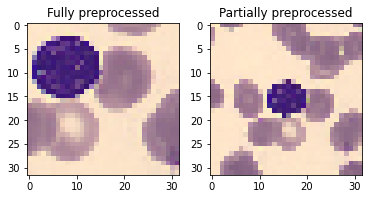

In [26]:
image = Image.open(paths[0])
final_cropped = get_transform(True)(image)
final_uncropped = get_transform(False)(image)

print('Shape of the fully preprocessed image:', final_cropped.shape)
print('Shape of the partially preprocessed image:', final_uncropped.shape)

plt.subplot(1,2,1)
plt.imshow(T.ToPILImage()(final_cropped))
plt.title('Fully preprocessed')
plt.subplot(1,2,2)
plt.imshow(T.ToPILImage()(final_uncropped))
plt.title('Partially preprocessed')
plt.show()

## Saving in local to enable faster treatment
---

**Warning : The code of this section takes a very long time to run. It is intended to compute the folders trainset_preprocessed and testset_preprocessed that we must have sent you. I only display it here so that you can check if it runs properly.**

While the cells above allow to generate the preprocessed images from the dataset, this treatment takes a lot of time. To load and process all the images of the dataset, it took us about one hour and a half.

I decided to save the processed images on my computer and to join them to this notebook, so that you don't have to wait one hour and a half to transform all the images.

Here is the code that was used to create the two .zip files.

**1. Transforming the test set**

I created a new folder, `testset_preprocessed` (here the name are a bit changed so that it doesn't replace the folders you must already have charged), with the same architecture as `testset`, but containing .pt files instead of .jpg files.

This folder has then been downloaded as a .zip.

In [27]:
from pathlib import Path

Path('testset_preprocessed2/').mkdir(parents=True, exist_ok=True) # Creates the folder if it doesn't exist
print('Current files in the working directory:\n')
! ls --color

Current files in the working directory:

clinical_annotation.csv  sample_data            testset                trainset
DL_lymphocytosis.zip     sample_submission.csv  testset_preprocessed2


I then extracted the IDs of all the participants in the testing set, thanks to the `clinical_annotation.csv` file.

In [28]:
df_testset = pd.read_csv(clinical_path, index_col=0)
df_testset = df_testset[df_testset.LABEL == -1].reset_index(drop=True) # Keep only patients with label -1
id_test_patients = df_testset.ID.tolist()

Finally, for each patient I created an appropriate folder in `testset_preprocessed/`, containing all its image transformed.

Feel free to interrupt the running of the cell below; it took about 20 minutes to run.

In [29]:
## Process patient by patient
try :
  for patient_id in id_test_patients :
    print('Patient:', patient_id)
    Path('testset_preprocessed2/'+patient_id+'/').mkdir(parents=True, exist_ok=True)                                              # Creates the directory for the patient                 
    paths = [orig_test + patient_id + '/' + img_name for img_name in os.listdir(orig_test + patient_id)]                          # List of paths for the raw images
    new_paths = ['testset_preprocessed2/'+patient_id+'/'+img_name[:-4]+'.pt' for img_name in os.listdir(orig_test + patient_id)]  # List of paths to save the transformed images

    for idx, path in enumerate(paths) :
      image = imageio.imread(path)          # Load image
      image = get_transform(True)(image)    # Transform image
      image = T.ToPILImage()(image)         # Convert image to PIL for saving
      torch.save(image, new_paths[idx])     # Save image
  
  ## Zip and download the file
  !zip -r testset_preprocessed2.zip testset_preprocessed2
  files.download('testset_preprocessed2.zip')

except KeyboardInterrupt :
  print('>>> Preprocessing interrupted by the user.')
  pass

Patient: P71
Patient: P16
Patient: P114
Patient: P170
Patient: P98
Patient: P69
Patient: P92
Patient: P132
Patient: P81
Patient: P73
Patient: P143
Patient: P175
Patient: P56
Patient: P139
Patient: P152
Patient: P203
Patient: P75
Patient: P9
Patient: P24
Patient: P4
Patient: P32
Patient: P120
Patient: P138
Patient: P172
Patient: P57
Patient: P195
Patient: P68
Patient: P133
Patient: P14
Patient: P119
Patient: P7
Patient: P49
Patient: P93
Patient: P178
Patient: P58
Patient: P108
Patient: P197
Patient: P196
Patient: P86
Patient: P18
Patient: P188
Patient: P148
  adding: testset_preprocessed2/ (stored 0%)
  adding: testset_preprocessed2/P133/ (stored 0%)
  adding: testset_preprocessed2/P133/000050.pt (deflated 43%)
  adding: testset_preprocessed2/P133/000038.pt (deflated 49%)
  adding: testset_preprocessed2/P133/000048.pt (deflated 42%)
  adding: testset_preprocessed2/P133/000023.pt (deflated 27%)
  adding: testset_preprocessed2/P133/000031.pt (deflated 48%)
  adding: testset_preprocessed2/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

A quick test allows to make sure that the images can be re-loaded without loss of quality.

torch.Size([3, 32, 32])


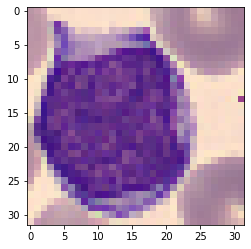

In [30]:
image = torch.load('testset_preprocessed2/P71/000003.pt')
plt.imshow(image)
image = T.ToTensor()(image)
print(image.shape)

**2. Transforming the train set**

Now I repeat the same operations for the training set.

In [31]:
from pathlib import Path

Path('trainset_preprocessed2/').mkdir(parents=True, exist_ok=True) # Creates the folder if it doesn't exist
print('Current files in the working directory:\n')
! ls --color

Current files in the working directory:

clinical_annotation.csv  sample_submission.csv  testset_preprocessed2.zip
DL_lymphocytosis.zip     testset                trainset
sample_data              testset_preprocessed2  trainset_preprocessed2


In [32]:
id_test_patients = df_clinical.ID.tolist()

try :
  for patient_id in id_test_patients[0:50] :
    print('Patient:', patient_id)

    Path('trainset_preprocessed2/'+patient_id+'/').mkdir(parents=True, exist_ok=True)                                              # Creates the directory for the patient                 
    paths = [orig_train + patient_id + '/' + img_name for img_name in os.listdir(orig_train + patient_id)]                         # List of paths for the raw images
    new_paths = ['trainset_preprocessed2/'+patient_id+'/'+img_name[:-4]+'.pt' for img_name in os.listdir(orig_train + patient_id)] # List of paths to save the transformed images
    
    # Transformation of each image of the patient
    for idx, path in enumerate(paths) :
      image = imageio.imread(path)          # Load image
      image = get_transform(True)(image)    # Transform image
      image = T.ToPILImage()(image)         # Convert image to PIL for saving
      torch.save(image, new_paths[idx])     # Save image


  !zip -r trainset_preprocessed.zip trainset_preprocessed
  files.download('trainset_preprocessed2.zip')

except KeyboardInterrupt :
  print('>>> Preprocessing interrupted by the user.')
  pass

Patient: P26
Patient: P183
Patient: P89
Patient: P123
Patient: P61
Patient: P112
Patient: P63
Patient: P184
Patient: P23
Patient: P100
Patient: P11
Patient: P111
Patient: P28
Patient: P192
Patient: P35
Patient: P27
Patient: P113
Patient: P33
Patient: P17
Patient: P126
Patient: P199
Patient: P176
Patient: P46
Patient: P44
Patient: P137
Patient: P13
Patient: P74
Patient: P134
Patient: P128
Patient: P0
Patient: P202
Patient: P157
Patient: P42
Patient: P161
Patient: P163
Patient: P159
Patient: P38
Patient: P190
Patient: P12
Patient: P115
Patient: P122
Patient: P116
Patient: P144
Patient: P15
Patient: P154
Patient: P48
Patient: P187
Patient: P200
Patient: P99
Patient: P150
	zip warning: name not matched: trainset_preprocessed

zip error: Nothing to do! (try: zip -r trainset_preprocessed.zip . -i trainset_preprocessed)


FileNotFoundError: ignored

# **4. Data Learning model**
---
---

## Datasets
---

I started by coding a function to easily return the clinical annotations associated to some patient IDs.

In [33]:
def return_data(df, ids):
  """
  Returns the lines of df that correspond to the IDs of a list.
  --------------------
  Input: data frame, list of 'Pxx'
  Output: dictionary
  """
  ages = []
  genders = []
  lymph_counts = []
  labels = []
  for id in ids:
    age, gender, lymph_count, label = df.loc[id, 'AGE'], df.loc[id, 'GENDER'], df.loc[id, 'LYMPH_COUNT'],  df.loc[id, 'LABEL']
    ages.append(age)
    genders.append(gender)
    lymph_counts.append(lymph_count)
    labels.append(label)
  return {'id': ids, 'age': ages, 'gender':genders, 'lymph_count':lymph_counts,  'label':labels}

Then I created the class `LymphoDataset`, which gathers all the information (clinical annotations and images) about a given list of patients. This dataset will later be used to create the data loaders necessary for the training of the model.

There are three ways of loading the images with `LymphoDataset` :

1.   Load raw images and process them partially (without cropping) : `orig=orig_train`, `transforms=get_transform(False)`

2.   Load raw images and process them completely (not recommended) : `orig=orig_train`, `transforms=get_transform(True)`

3.   Load preprocessed images : `orig=orig_train_preprocessed`, `transforms=None`



In [34]:
class LymphoDataset(torch.utils.data.Dataset):
    def __init__(self, orig, patients_list, ages, lymph_count, labels, transforms=None, local_path=None):
      """
      Initializes the dataset with a list of transformations to apply to the
      images, a list of the patient IDs, and a dictionary to organize the 
      images with the patient dependence.
      """
      self.transforms = transforms
      self.patients_list = patients_list #
      # Gather information patient by patient
      self.img_dict = {idx: {'id': patient_id,                                                                              # Patient ID
                            'paths': [orig + patient_id + '/' + img_name for img_name in os.listdir(orig + patient_id)],    # List of paths to the patient images
                            'age': ages[idx],                                                                               # Age of the patient
                            'lymph_count': lymph_count[idx],                                                                # Lymphocyte count of the patient                     
                            'label': labels[idx]}                                                                           # Label of the patient
                       for idx, patient_id in enumerate(patients_list)} 
       
      # Load and transform each image     
      for idx in self.img_dict.keys() :

        if self.transforms : # If we load the raw images
          images = [Image.open(path) for path in self.img_dict[idx]['paths']]
          images = torch.cat([self.transforms(image)[None, :, :, :] for image in images], axis=0)
    
        else : # If we load the preprocessed images
          images = [torch.load(path) for path in self.img_dict[idx]['paths']]
          images = torch.cat([T.ToTensor()(image)[None, :, :, :] for image in images], axis=0)
      
        self.img_dict[idx]['images'] = images                             



    def __getitem__(self, idx):  
      """
      Loads the components of the dataset and returns the objects as tensors.
      """ 
      images = self.img_dict[idx]['images']
      label = self.img_dict[idx]['label']
      age = self.img_dict[idx]['age']
      lymph_count = self.img_dict[idx]['lymph_count']
      id = self.img_dict[idx]['id']

      # Convert everything to tensor
      lymph_count = torch.tensor([lymph_count], dtype=torch.float32)
      age = torch.as_tensor([age], dtype=torch.float32)
      label = torch.as_tensor([label], dtype=torch.float32)
        
      data = {"age": age,
              "lymph_count": lymph_count,
              "images": images,
              "label": label,
              "id": id}
      return data


    def __len__(self):
      """Returns the number of patients."""
      return len(self.patients_list)


In order to create a data loader from `LymphoDataset`, I need a custom function to pass to the argument `collate_fn` of `torch.utils.data.DataLoader`, due to the custom architecture of our dataset.

In [35]:
def custom_fn(batch):
  """
  Custom function to be called as in the creation of the data loaders :
  collate_fn = custom_fn.
  --------------------
  Input: batch
  Output: dictionary
  """
  elem = batch[0].keys()
  return {key : torch.cat(gen_list(key, batch), axis=0) if key != 'id' else gen_list(key, batch) for key in elem}


def gen_list(key, batch):
  """ Function called in custom_fn to extract the data from a batch."""
  if key == 'images':
    return [d[key] for d in batch]
  elif key =='id':
    return [d[key] for d in batch]
  else:
    return [d[key][None, :] for d in batch]

## Model definition
---

My network is composed of three main parts:


1.   The **image** model (uses the information from the images): composed of a DenseNet Layer in the role of *feature extractor*, an *aggregator layer* and a *fully connected layer*.
2.   The **clinical** model (uses the clinical annotations): a multi-layer perceptron
3.   The **weights** model (learns how to combine the outputs of the image model and the clinical model): a multi-layer perceptron





In [36]:
class NewNetwork(nn.Module):
  def __init__(self):
    super(NewNetwork, self).__init__()
        
    self.relu = nn.LeakyReLU(inplace = True)
    self.bn = nn.BatchNorm2d(num_features = 8)
    
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 24, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels = 32, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)


    self.fullyconnected = nn.Sequential(
        nn.Linear(3072, 1536),
        nn.LeakyReLU(),
        nn.Linear(1536, 768),
        nn.LeakyReLU(),
        nn.Linear(768, 48),
        nn.LeakyReLU(),
        nn.Linear(48, 24),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(24, 1), 
    )

    self.mlp = nn.Sequential(
        nn.Linear(2, 8),
        nn.LeakyReLU(),
        nn.Linear(8, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 64),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 1),
    )

    self.weights = nn.Sequential(
        nn.Linear(3072 + 2, 1536),
        nn.LeakyReLU(),
        nn.Linear(1536, 768),
        nn.LeakyReLU(),
        nn.Linear(768, 48),
        nn.LeakyReLU(),
        nn.Linear(48, 24),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(24, 2), 
        nn.Softmax()
    )
  
  def forward(self, x_images, x_clinical):
    """
    Input: Scores of images and clinical model
    Output: Mean score to compare to label
    """

    # Image Model

    x_1 = self.conv1(x_images)
    x_1 = self.relu(self.bn(x_1))

    x_2 = self.conv2(x_1)
    x_2 = self.relu(self.bn(x_2))

    x_3 = self.conv3(torch.cat((x_1, x_2), dim=1))
    x_3 = self.relu(self.bn(x_3))

    x_4 = self.conv4(torch.cat((x_1, x_2, x_3), dim=1))
    x_4 = self.relu(self.bn(x_4))

    x_5 = self.conv5(torch.cat((x_1, x_2, x_3, x_4), dim=1))
    x_5 = self.relu(self.bn(x_5))

    x_images = x_images.view(x_5.size(0), -1)
    x_images_agg = torch.logsumexp(x_images, dim=0, keepdim=True)     # Aggregating function
    x_images = self.fullyconnected(x_images_agg)                      # Fully connected layers
    x_images = torch.sigmoid(x_images)                                # Sigmoid to return a label
    x_images = x_images.view(-1,1)

    # Weight Model
    x_weights = self.weights(torch.cat((x_images_agg, x_clinical.view(-1,2)), dim=1)) #Calculate the associated weights

    # Clinical Model
    x_clinical = x_clinical.view(-1,2)
    x_clinical = self.mlp(x_clinical)               # Multi-Layer Perceptron
    x_clinical = torch.sigmoid(x_clinical)          # Sigmoid to return a label
    x_clinical = x_clinical.view(-1,1)

    x = torch.sum(torch.cat((x_images, x_clinical), dim=1) * x_weights, dim=1, keepdim=True)
    x = x.view(-1, 1)
    
    return x

## Training and testing functions
---

The last thing to do was to compute the functions performing the training of the model, and evaluating its metrics.

I started by the `train_walk_around` function.

In [37]:
def train_walk_around(train_loader, model, learning_rate, epochs, batch_size, criterion, optimizer, threshold, test_loader=None):
  """
  Trains a model given parameters (learning_rate, epochs, batch_size, threshold)
  and torch objects (criterion, optimize) on the data loader train_loader. 
  Can also evaluate the model epoch by epoch on the optional data loader test_loader.
  --------------------
  Outputs:
  - list_ba : List of the balanced accuracy computed on  train_loader, epoch by epoch.
  - list_ba_test : If test_loader=None, empty list. Else, list of the balanced 
  accuracy computed on test_loader, epoch by epoch.
  - list_loss : List of the loss of the model, epoch by epoch.
  """

  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr= learning_rate * 10, steps_per_epoch= int(len(train_loader)/batch_size)+2, epochs=epochs)

  # Prepares outputs
  list_ba = []
  list_ba_test = []
  list_loss = []

  # Aesthetics : progress bar
  epoch_progress = widgets.IntProgress(value=1, min=0, max=epochs, description=f"", layout=widgets.Layout(width='40%'), style={'bar_color': 'black'}, readout=True, readout_format='d')
  display(epoch_progress)

  
  for epoch_no in range(epochs): # The model is trained {epochs} times.

    # Aesthetics : progress bar 
    epoch_progress.description = f'{epoch_no +1} / {epochs}'
    epoch_progress.value = epoch_no+1
    tot_steps = len(train_loader)
    progress = widgets.IntProgress(value=0, min=0, max=tot_steps, description=f"", layout=widgets.Layout(width='40%'), style={'bar_color': 'blue'}, readout=True, readout_format='d')
    display(progress)
    infoBack = widgets.Valid(readout=f"")
    display(infoBack)

    ## Initialize loss
    model.train()
    total_loss = 0
    outputs = []    # Stores the outputs of the model 
    labels = []     # Stores the true label 
    i = 0           # For incrementation


    for idx, batch in enumerate(train_loader): # Each batch corresponds to a participant

      # Aesthetics
      progress.value += 1

      ## Computes outputs
      optimizer.zero_grad()
      img, clinical, label = batch['images'], torch.cat( (batch['age'],batch['lymph_count']), dim=0), batch['label'] 
      output = model(img, clinical)
      outputs.append(output)
      labels.append(label) 

      i += 1
      if i < batch_size and idx < len(train_loader)-1: 
        continue
      

      ## Backpropagation
      #Aesthetics
      progress.style = {'bar_color': 'green'}
      infoBack.readout = 'Backpropagate!'
      
      #Concatenation of outputs and labels after batch_size time
      outputs = torch.cat(outputs, dim=0)
      labels = torch.cat(labels, dim=0)
      
      #Forward + Backward + Optimize
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()
      
      total_loss += loss.detach().item()
      outputs = []
      labels = []
      i = 0

      # Aestetics
      infoBack.readout = ""
      progress.style = {'bar_color': 'blue'}


    ## State of the model after the epoch :

    # Aestetics and stats on train_loader
    progress.style = {'bar_color': 'red'}
    infoBack.readout = 'Evaluating the model...'
    y_pred, y_label = test(model, train_loader, threshold) 
    progress.close()
    infoBack.close()
    ba = balanced_accuracy_score(y_label, y_pred)
    list_loss.append(total_loss/batch_size)
    
    # Stats on test_loader
    if test_loader :
      y_pred, y_label = test(model, test_loader, threshold)
      ba_test = balanced_accuracy_score(y_label, y_pred)
      list_ba.append(ba)
      list_ba_test.append(ba_test)
  
  return list_ba, list_ba_test, list_loss

Then I had to create a function to evaluate the model.

Since the training set is unbalanced, I know that there is a biase towards predicting more 1 (unhealthy). I chose to apply a threshold in the `test` function to counterbalance this effect; in practice, I use `threhsold` around 0.6, so it is more difficult to predict "1" labels.


In [38]:
def test(model, data_loader, threshold):
  """
  Evaluates a trained model on a test data loader.
  Returns the prediction of the labels, and the true labels.
  --------------------
  Input: trained model, data loader
  Output: list, list
  """

  model.eval()

  y_pred_list = []
  y_label = []

  with torch.no_grad():
      for X_batch in data_loader:

          img, clinical, label = X_batch['images'], torch.cat((X_batch['age'],X_batch['lymph_count']), dim=0), X_batch['label']
          y_test_pred = model(img, clinical)
          y_label += [X_batch['label'].cpu().numpy()]

          if y_test_pred.item() > threshold: # Counterbalances the inequality of 0 and 1 in the training set
            y_pred_tag = torch.tensor(1.0)
          else:
            y_pred_tag = torch.tensor(0.0)
          y_pred_list.append(y_pred_tag.cpu().numpy())
  
  y_pred_list = [a.item() for a in y_pred_list]
  y_label = [a.item() for a in y_label]
  return  y_pred_list, y_label

# **5. Training of the model**
---
---

## Test of the functions
---

I start by training and testing the model on fixed parameters, just to check if it runs and learns through its learning.

### Data loaders

To create the data loaders, I must first define a training and a validation set.

In [39]:
# Separate the IDs
train_id_patient, valid_id_patient = train_test_split(df_clinical.ID.tolist(), test_size=0.25, random_state=42)

# Separate the clinical datasets
dict_train = return_data(df_clinical.set_index(['ID']), train_id_patient)
dict_valid = return_data(df_clinical.set_index(['ID']), valid_id_patient)

Next, I extract the information contained in the dictionaries `dict_train` and `dict_test`. This will allow us to gather clinical information and images into a `LymphoDataset`.

In [40]:
# Training set
patients_list_train = dict_train['id']
ages_train = dict_train['age']
lymph_counts_train = dict_train['lymph_count']
labels_train = dict_train['label']

# Validation set
patients_list_valid = dict_valid['id']
ages_valid = dict_valid['age']
lymph_counts_valid = dict_valid['lymph_count']
labels_valid = dict_valid['label']

The last thing to do is to create the datasets and data loaders. I chose to use two workers (`num_workers=2`) for the dataset because my computer was not powerful enough to handle more.

Two possible ways of loading the dataset are proposed at each step. Loading the dataset using the preprocessed images is recommended to get the best from the model, but it is possible to comment this option and uncomment the other one.

In [42]:
## Load raw images and partially preprocess them :

train_dataset = LymphoDataset(orig_train, patients_list_train, ages_train, lymph_counts_train, labels_train, get_transform(False))
valid_dataset = LymphoDataset(orig_train, patients_list_valid, ages_valid, lymph_counts_valid, labels_valid, get_transform(False))


## Load preprocessed images :

#train_dataset = LymphoDataset(orig_train_preprocessed, patients_list_train, ages_train, lymph_counts_train, labels_train, transforms=None)
#valid_dataset = LymphoDataset(orig_train_preprocessed, patients_list_valid, ages_valid, lymph_counts_valid, labels_valid, transforms=None)

In [43]:
## Create the data loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_fn)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_fn)

### Training

I can see how the model runs on toy parameters, just to check that everything works fine.

In [44]:
learning_rate = 10**-3
n_epochs = 5
batch_size = 8
threshold = 0.6 

# Put the network on GPU
model = NewNetwork()
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
list_ba, list_ba_valid, list_loss = train_walk_around(train_loader, model, learning_rate, n_epochs, batch_size, criterion, optimizer, threshold, valid_loader)

IntProgress(value=1, layout=Layout(width='40%'), max=5, style=ProgressStyle(bar_color='black'))

IntProgress(value=0, layout=Layout(width='40%'), max=122, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=122, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=122, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=122, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=122, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


## Validation

Now, I have to find the best hyper-parameters for our model :
*   Number of epochs
*   Learning rate
*   Batch size
*   Threshold


In order to properly adjust them, I will to go through a validation process. I will create training and validation sets from our base training set, and then train our model and evaluate it with different combinations of hyper parameters.

In order to do so, I first need to create an array containing the label of each patient, where there are as many labels as images. This will allow to split the data at the group level.


In [45]:
all_IDs =  df_clinical['ID'].tolist()
all_labels = df_clinical['ID'].tolist()

patients_array = []

for idx, patient_id in enumerate(all_IDs) :
  for img in os.listdir(orig_train + patient_id) :
    patients_array.append(all_labels[idx])

patients_array = np.array(patients_array)

I chose to use a repeated hold-out strategy, since this provides more easily interpretable results compared with the K-fold strategy.

Because the healthy and unhealthy patients are unequally represented in the dataset, I hesitated to split it with stratified groups, but given that our dataset is not so large (there are 202 patients) it might have represented a detrimental loss of information. Moreover, the unbalanced problem must be resolved thanks to the `threshold` added to the model.

I will create different splitting of the data into train and validation sets.
These new data loaders are created before the main loop, so that I don't have to load them at each time.

In [48]:
from sklearn.model_selection import GroupShuffleSplit

nb_splits = 3
gss = GroupShuffleSplit(n_splits=nb_splits, test_size=0.2, random_state=42)
train_loaders = []
valid_loaders = []

for i, (train_idx, valid_idx) in enumerate(gss.split(patients_array, patients_array, patients_array)) :

    patients_train, patients_valid = np.unique(patients_array[train_idx]), np.unique(patients_array[valid_idx])

    # Define the train loader
    data_train = return_data(df_clinical.set_index(['ID']), np.unique(patients_train))
    lymphoData_train = LymphoDataset(orig_train, data_train['id'], data_train['age'], data_train['lymph_count'], data_train['label'], transforms=get_transform(False))
    #lymphoData_train = LymphoDataset(orig_train_preprocessed, data_train['id'], data_train['age'], data_train['lymph_count'], data_train['label'], transforms=None)
    train_loader = torch.utils.data.DataLoader(lymphoData_train, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_fn)

     # Define the validation loader
    data_valid = return_data(df_clinical.set_index(['ID']), np.unique(patients_valid))
    lymphoData_valid = LymphoDataset(orig_train, data_valid['id'], data_valid['age'], data_valid['lymph_count'], data_valid['label'], transforms=get_transform(False))
    #lymphoData_valid = LymphoDataset(orig_train_preprocessed, data_valid['id'], data_valid['age'], data_valid['lymph_count'], data_valid['label'], transforms=None)
    valid_loader = torch.utils.data.DataLoader(lymphoData_valid, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_fn)

    train_loaders.append(train_loader)
    valid_loaders.append(valid_loader)

Now I can create the main loop that will train the model on the different possible parameters and store the results.

I had computation limits, because long sessions on Google Colab eventually always crashed, leaving us without any information. To by pass that problem, I decided to choose each combination of parameters by hand instead of going through a long loop, and I stored the results (balanced accuracy on the training set, balanced accuracy on the validation set, and loss) on .csv files that I downloaded after each training.

In [49]:
# Examples of parameters combination used in the validation process
learning_rate = 10**-3
batch_size = 14
threshold = 0.65
n_epochs = 40


## Saving
filename = f'lr-{learning_rate}_batchsize-{batch_size}_threshold-{threshold}_nepochs-{n_epochs}.csv'
saveTxt = open(filename, 'w')
saveTxt.write('split,epoch,ba_train,ba_valid,loss\n')

## Training
for i in range(nb_splits) :

  print('-------------------')
  print(f'Split n°{i+1}')
  print('-------------------')

  # Train the model
  model = NewNetwork()
  criterion = nn.BCELoss(reduction='sum')
  optimizer = torch.optim.Adam(model.parameters(), learning_rate)
  ba_train, ba_valid, loss = train_walk_around(train_loaders[i], model, learning_rate, n_epochs, batch_size, criterion, optimizer, threshold, valid_loaders[i])

  for epoch in range(len(ba_train)) :
    saveTxt.write(f'{i},{epoch},{ba_train[epoch]},{ba_valid[epoch]},{loss[epoch]}\n')

files.download(filename)
saveTxt.close()

-------------------
Split n°1
-------------------


IntProgress(value=1, layout=Layout(width='40%'), max=40, style=ProgressStyle(bar_color='black'))

IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


-------------------
Split n°2
-------------------


IntProgress(value=1, layout=Layout(width='40%'), max=40, style=ProgressStyle(bar_color='black'))

IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


-------------------
Split n°3
-------------------


IntProgress(value=1, layout=Layout(width='40%'), max=40, style=ProgressStyle(bar_color='black'))

IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


IntProgress(value=0, layout=Layout(width='40%'), max=130, style=ProgressStyle(bar_color='blue'))

Valid(value=False, readout='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, I needed to visualise our data to see what paramerers perform best, and for what number of epochs.

Due to a lack of computation power, I didn't have the opportunity to test as many parameters as I wished to. I sent you a .zip file containing all the information concerning the parameters we tested; please upload it on Colab and unzip it to be able to see the evolution of the balanced accuracies and the loss in different contexts.

In [52]:
! unzip -q validation.zip
print('File unzipped')

File unzipped


Please make sure that the unzipped folder `validation` is present in your current working directory, and change `orig_validation` accordingly if not.

In [53]:
!ls --color
orig_validation = 'validation/'

clinical_annotation.csv                              testset_preprocessed2
DL_lymphocytosis.zip                                 testset_preprocessed2.zip
lr-0.001_batchsize-14_threshold-0.65_nepochs-40.csv  trainset
sample_data                                          trainset_preprocessed2
sample_submission.csv                                validation
testset                                              validation.zip


I then load all the .csv files in order to manipulate them as data frames.

In [54]:
## Prepare regex to extract the information of the parameters from the name of the file
import re
lr = re.compile('lr-(\d+\.?\d*)')
batchsize = re.compile('(.*)batchsize-(\d+)')
thresh = re.compile('(.*)threshold-(\d+\.?\d*)')
nepochs = re.compile('(.*)nepochs-(\d+)')


## Load all the .csv files
data_validation = []
learning_rate = []
batch_size = []
threshold = []
n_epochs = []


for filename in os.listdir(orig_validation) :
  # Load the data frame
  data_validation.append(pd.read_csv(orig_validation+filename)) 
  # Extract the parameters
  learning_rate.append(lr.match(filename).group(1)) 
  batch_size.append(batchsize.match(filename).group(2))
  threshold.append(thresh.match(filename).group(2))
  n_epochs.append(nepochs.match(filename).group(2))

I can now plot the evolution of the balanced accuracy on the training and on the validation sets, as well as the evolution of the loss, for each .csv file.

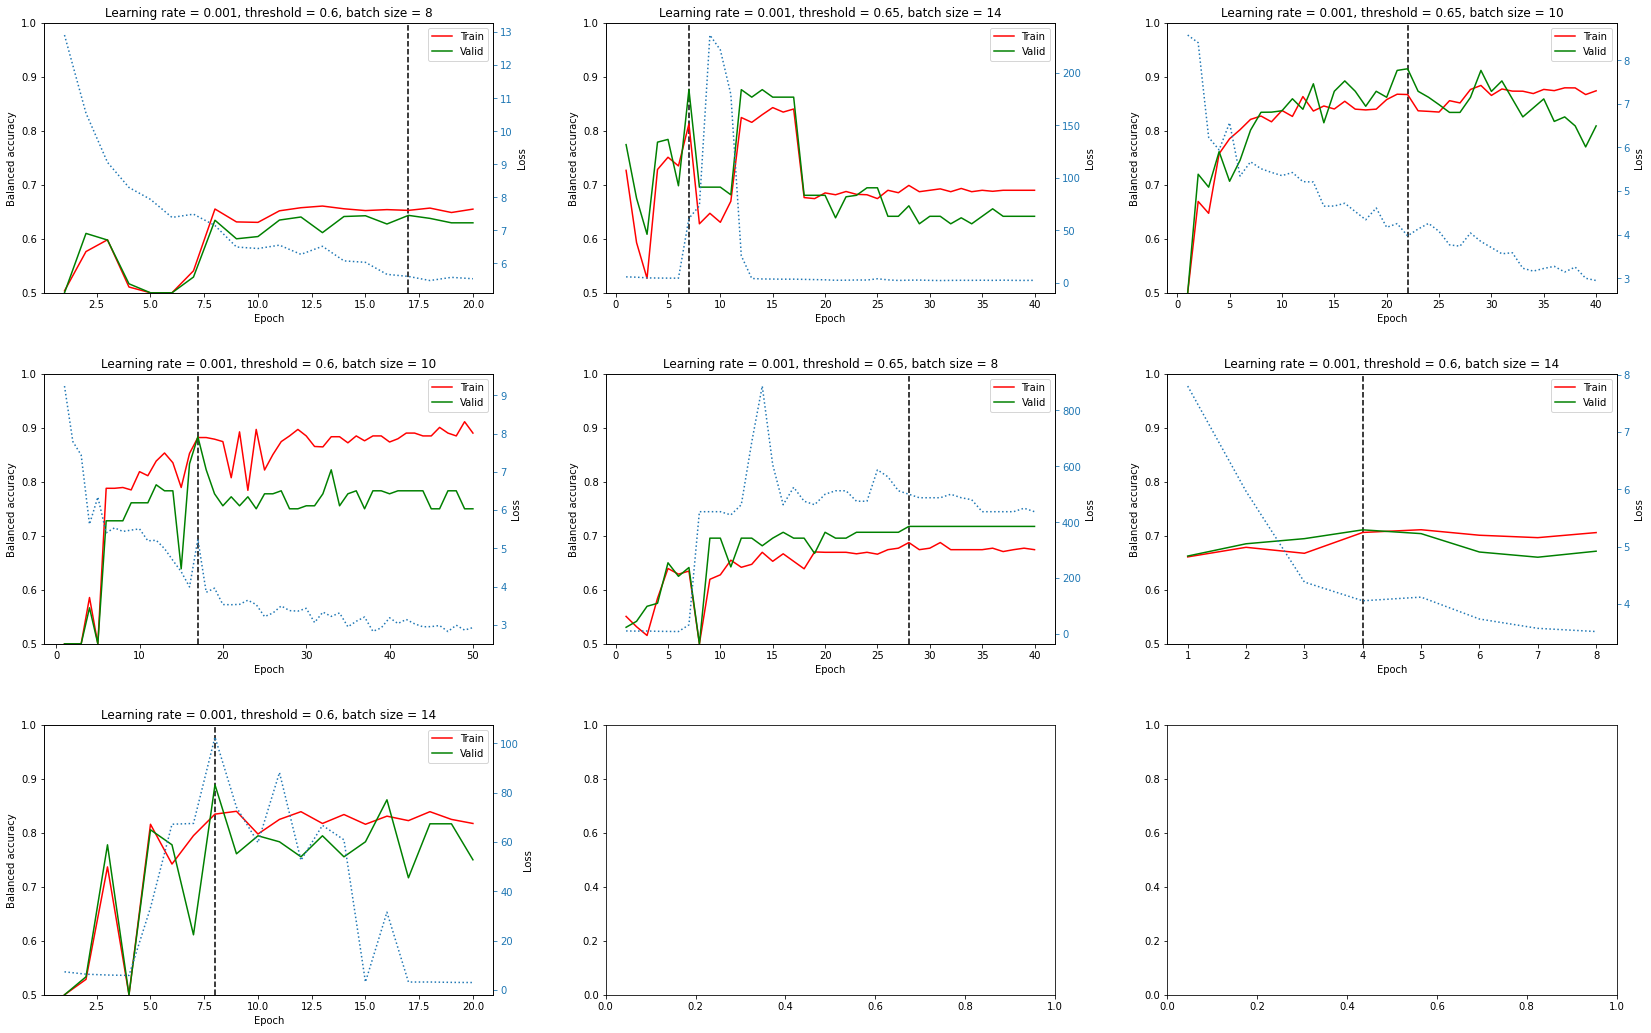

In [55]:
## Parameters of the overall plot
cols = 3
rows = ceil(len(data_validation)/cols)
fig,ax = plt.subplots(rows, cols, figsize=(28,rows*5))
plt.subplots_adjust(left=0.12, right=0.9, top=0.95, bottom=0.05, wspace=0.25, hspace=0.3)


## Storage of the best combinations
best_epoch = []
val_best_ba_valid = []


## Plot for each file
for i, df in enumerate(data_validation) :

  epochs = np.arange(1, int(n_epochs[i])+1)

  # Average the data over all the splits
  ba_train = np.array(df['ba_train'][df['split'] == 0])
  ba_valid = np.array(df['ba_valid'][df['split'] == 0])
  loss = np.array(df['loss'][df['split'] == 0])
  nb_splits = max(df['split'])
  for split in range(1, nb_splits) :
    ba_train = ba_train + np.array(df['ba_train'][df['split'] == split])
    ba_valid = ba_valid + np.array(df['ba_valid'][df['split'] == split])
    loss = loss + np.array(df['loss'][df['split'] == 0])
  ba_train = ba_train/nb_splits
  ba_valid = ba_valid/nb_splits
  loss = loss/nb_splits

  # Find the best balanced accuracy on the validation set
  best_epoch.append(np.argmax(ba_valid))
  val_best_ba_valid.append(ba_valid[best_epoch[i]])

  # Make the plot
  plt.subplot(rows, cols, i+1)
  plt.title(f'Learning rate = {learning_rate[i]}, threshold = {threshold[i]}, batch size = {batch_size[i]}')
  plt.plot(epochs, ba_train, label='Train', color='red')  # Plot balanced accuracy
  plt.plot(epochs, ba_valid, label='Valid', color='green')
  plt.vlines(best_epoch[i]+1, 0.5, 1, linestyle='dashed', color='k')
  plt.xlabel('Epoch')
  plt.ylabel('Balanced accuracy')
  plt.ylim(0.5,1)
  plt.legend()
  ax = plt.twinx()                                        # Plot loss
  ax.tick_params(colors='C0')
  plt.plot(epochs, loss, linestyle='dotted', color='C0')
  plt.ylabel('Loss', color='k')

  

plt.show()

The red lines correspond to the balanced accuracy on the training set, the green lines to the balanced accuracy on the validation set, the blue dotted line corresponds to the loss (linked to the right y-axis), and the vertical dashed line marks the epoch where the balanced accuracy on the validation set is at its maximum.

Now, I can finally see what combination of parameters is the best :

In [ ]:
best_combination = np.argmax(val_best_ba_valid)
print(f'The best combination of parameters is achieved for the plot n°{best_combination+1}.\nThe maximum balanced accuracy on the validation set equals {round(val_best_ba_valid[best_combination], 3)}.')

best_batchsize = int(batch_size[best_combination])
best_learningrate = float(learning_rate[best_combination])
best_threshold = float(threshold[best_combination])
max_epoch = int(best_epoch[best_combination])

print('\nThe final submission on Kaggle will be computed with the following parameters :')
print(f'  - batch size:    {best_batchsize}')
print(f'  - learning rate: {best_learningrate}')
print(f'  - threshold:     {best_threshold}')
print(f'And the training of the model will be stopped after epoch n°{max_epoch}.')

The best combination of parameters is achieved for the plot n°2.
The maximum balanced accuracy on the validation set equals 0.915.

The final submission on Kaggle will be computed with the following parameters :
  - batch size:    10
  - learning rate: 0.001
  - threshold:     0.65
And the training of the model will be stopped after epoch n°21.
